In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
from sklearn import model_selection
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

In [2]:
image_path = "/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/"
mask_path = "/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks/"

In [3]:
image_list = sorted(glob(image_path + "*.jpg"))[0:2000]
mask_list = sorted(glob(mask_path + "*.jpg"))[0:2000]

In [4]:
num_classes=2
IMG_HEIGHT=256
IMG_WIDTH=256
IMG_CHANNELS=3
n_features=16

In [5]:
def binarylab(labels):
    x = np.zeros([labels.shape[0],labels.shape[1],2])  
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
             # Get the color at the pixel
            color = labels[i, j]
             # Check if the color is close to red
            if np.allclose(color, [255,255,255], atol=10):  # Water (White)
                color_idx = 1
            else:
                color_idx = 0  # Black (Background)
            x[i, j, color_idx] = 1
    return x

def make_dataset(image_list, mask_list):
  images = []
  masks = []
    
  for img, mask in zip(image_list, mask_list):
    images.append(cv2.cvtColor(cv2.resize(cv2.imread(img), (IMG_HEIGHT,IMG_WIDTH)), cv2.COLOR_BGR2RGB))      
    masks.append(binarylab(cv2.cvtColor(cv2.resize(cv2.imread(mask), (IMG_HEIGHT,IMG_WIDTH)), cv2.COLOR_BGR2RGB)))
        
  images = np.array(images)
  masks = np.array(masks)
  return images, masks

In [6]:
image,mask = make_dataset(image_list, mask_list)

In [7]:
unique_colors = np.unique(mask.reshape(-1, mask.shape[3]),axis=0)
num_unique_colors = unique_colors.shape[0]
print(f"Number of unique colors in the mask dataset : {num_unique_colors}")
print(f"Unique colors are :{unique_colors}")

Number of unique colors in the mask dataset : 2
Unique colors are :[[0. 1.]
 [1. 0.]]


In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(image, mask, test_size = 0.2, random_state = 3)

print(X_train.shape, X_test.shape)

(1600, 256, 256, 3) (400, 256, 256, 3)


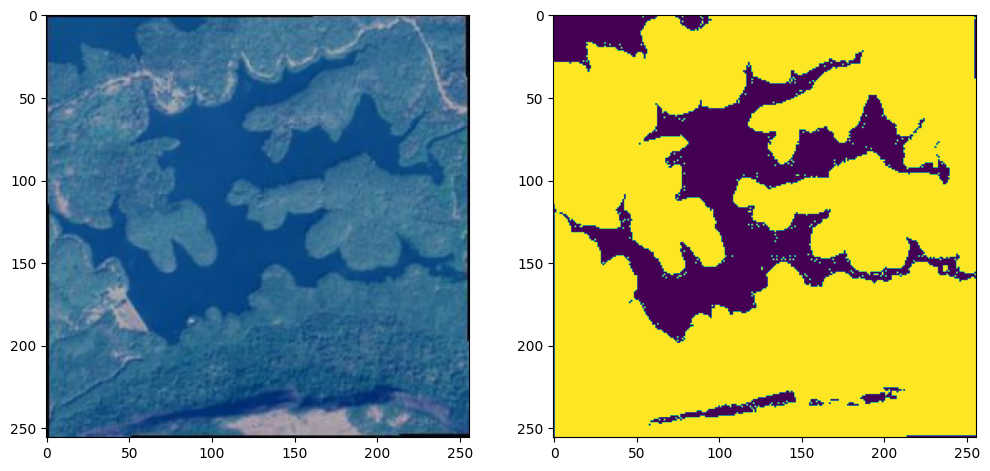

In [9]:
import random
import numpy as np
image_number = random.randint(0, len(image))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(image[image_number])
plt.subplot(122)
plt.imshow(mask[image_number][:,:,0])
plt.show()

In [10]:
from keras import backend as K
def jaccard_coef(y_true, y_pred):
    y_true_f = tf.argmax(y_true, axis=-1)
    y_pred_f = tf.argmax(y_pred, axis=-1)
    jaccard = 0
    for i in range(num_classes):
        y_true_i = tf.cast(tf.equal(y_true_f, i), K.floatx())
        y_pred_i = tf.cast(tf.equal(y_pred_f, i), K.floatx())
        intersection = tf.reduce_sum(y_true_i * y_pred_i)
        union = tf.reduce_sum(y_true_i) + tf.reduce_sum(y_pred_i) - intersection
        jaccard += (intersection + 1.0) / (union + 1.0)
    return jaccard / num_classes

def dice_coef(y_true, y_pred):
    y_true_f = tf.argmax(y_true, axis=-1)
    y_pred_f = tf.argmax(y_pred, axis=-1)
    dice = 0
    for i in range(num_classes):
        y_true_i = tf.cast(tf.equal(y_true_f, i), K.floatx())
        y_pred_i = tf.cast(tf.equal(y_pred_f, i), K.floatx())
        intersection = tf.reduce_sum(y_true_i * y_pred_i)
        dice += (2. * intersection + 1.0) / (tf.reduce_sum(y_true_i) + tf.reduce_sum(y_pred_i) + 1.0)
    return dice / num_classes


In [11]:
metrics = ['accuracy', jaccard_coef, dice_coef, 'recall' , 'precision']

In [12]:
def multi_unet_model(num_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

In [13]:
model = multi_unet_model(num_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    147,584 │ dropout_3[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]  

 Total params: 1,941,122 (7.40 MB)

 Trainable params: 1,941,122 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
c1 = tf.keras.callbacks.EarlyStopping(mode='max',monitor='val_jaccard_coef', patience = 10, restore_best_weights = True)
# Using Adam
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=metrics)
history = model.fit(np.array(X_train,dtype='float16'),np.array(y_train,dtype='float16'),epochs=500,verbose=1,batch_size=8, callbacks = [c1],validation_split=0.1) 

Epoch 1/500


I0000 00:00:1728018412.625273      67 service.cc:145] XLA service 0x7b01d8066890 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728018412.625332      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  3/180 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.7068 - dice_coef: 0.4393 - jaccard_coef: 0.3661 - loss: 38.2679 - precision: 0.7201 - recall: 0.7068    

I0000 00:00:1728018431.919049      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/180 ━━━━━━━━━━━━━━━━━━━━ 35s 51ms/step - accuracy: 0.6441 - dice_coef: 0.4883 - jaccard_coef: 0.3740 - loss: 5.8541 - precision: 0.6447 - recall: 0.6441 - val_accuracy: 0.7085 - val_dice_coef: 0.4642 - val_jaccard_coef: 0.3823 - val_loss: 0.5788 - val_precision: 0.7085 - val_recall: 0.7085
Epoch 2/500
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7158 - dice_coef: 0.4670 - jaccard_coef: 0.3868 - loss: 0.5432 - precision: 0.7158 - recall: 0.7158 - val_accuracy: 0.7096 - val_dice_coef: 0.4673 - val_jaccard_coef: 0.3845 - val_loss: 0.5072 - val_precision: 0.7096 - val_recall: 0.7096
Epoch 3/500
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7134 - dice_coef: 0.4885 - jaccard_coef: 0.4010 - loss: 0.5114 - precision: 0.7134 - recall: 0.7134 - val_accuracy: 0.7683 - val_dice_coef: 0.7367 - val_jaccard_coef: 0.5992 - val_loss: 0.4809 - val_precision: 0.7683 - val_recall: 0.7683
Epoch 4/500
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.7774 - dice_coef: 0.7369 

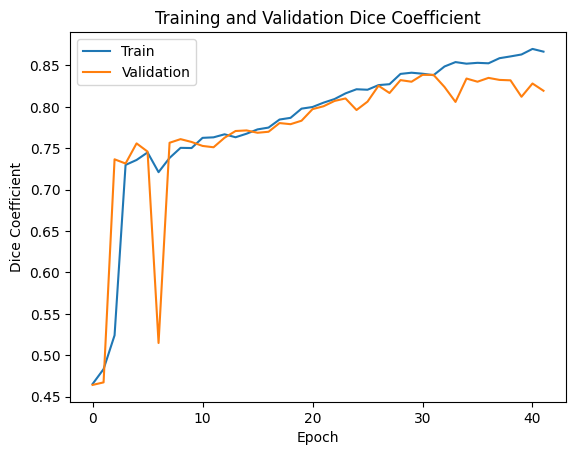

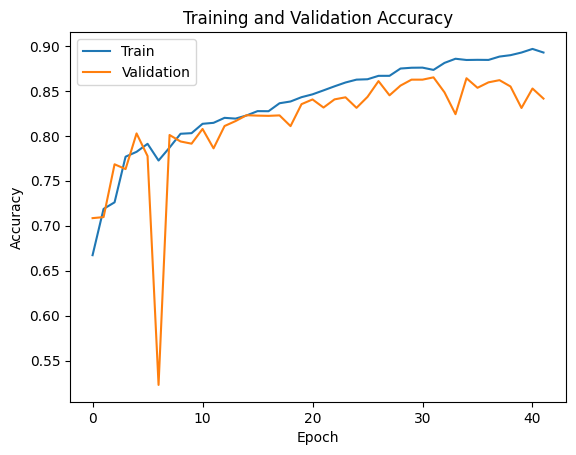

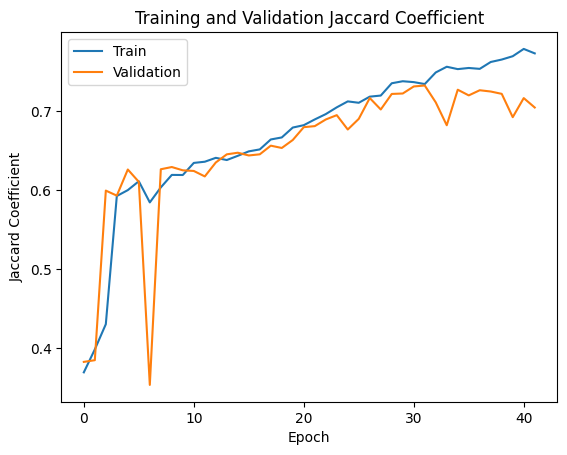

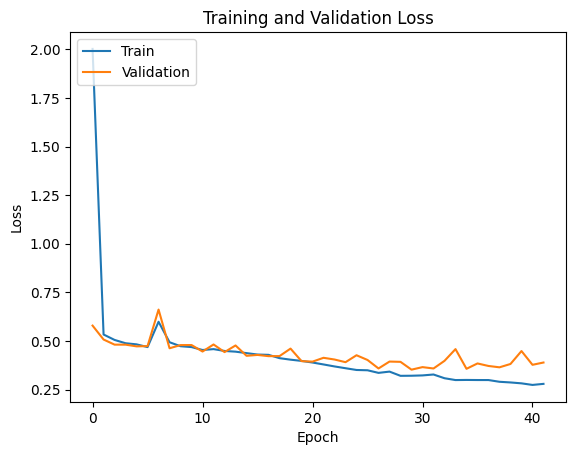

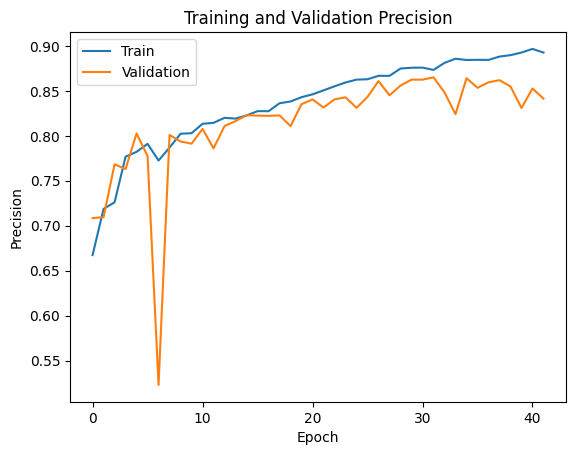

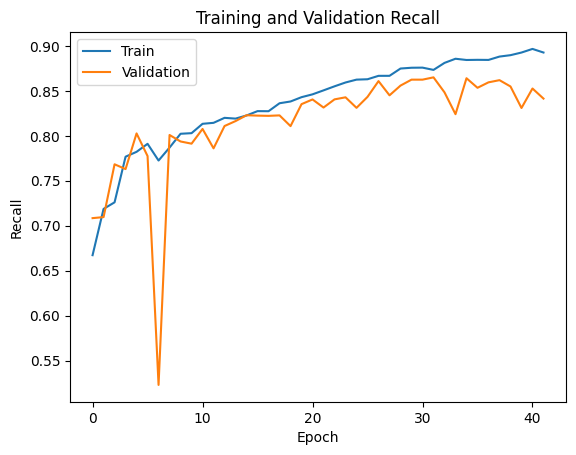

In [15]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Training and Validation Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['jaccard_coef'])
plt.plot(history.history['val_jaccard_coef'])
plt.title('Training and Validation Jaccard Coefficient')
plt.ylabel('Jaccard Coefficient')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Training and Validation Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Training and Validation Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
model.evaluate(X_test, y_test)

13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - accuracy: 0.8914 - dice_coef: 0.8697 - jaccard_coef: 0.7737 - loss: 0.3038 - precision: 0.8914 - recall: 0.8914


[0.3013255298137665,
 0.8902227878570557,
 0.7764832377433777,
 0.8715439438819885,
 0.8902227878570557,
 0.8902227878570557]

In [17]:
from sklearn.metrics import jaccard_score, f1_score 
from keras import backend as K

# Get predictions for the test data
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=-1)
y_test_argmax = np.argmax(y_test, axis=-1)

# Jaccard Index (IoU) for each class
from keras.metrics import MeanIoU
iou_keras = MeanIoU(num_classes=num_classes)
iou_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", iou_keras.result().numpy())

# Jaccard Index using sklearn
iou_per_class = jaccard_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average=None)
print("IoU per class:", iou_per_class)

# Dice Coefficient (F1 Score) for each class
dice_per_class = f1_score(y_test_argmax.flatten(), y_pred_argmax.flatten(), average=None)
print("Dice Coefficient per class:", dice_per_class)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Mean IoU = 0.77347517
IoU per class: [0.85397554 0.69336347]
Dice Coefficient per class: [0.92123712 0.81891866]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


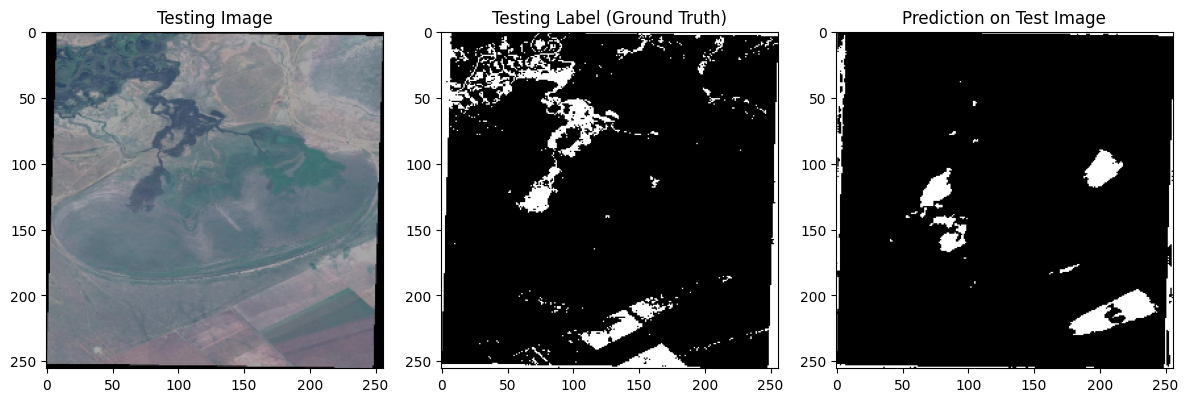

In [18]:
import random
test_img_number = random.randint(0, len(X_test) - 1)  # Ensure correct range
test_img = X_test[test_img_number]
ground_truth = y_test_argmax[test_img_number]

# Expand dimensions to fit model input
test_img_input = np.expand_dims(test_img, 0)
prediction = model.predict(test_img_input)
predicted_img = np.argmax(prediction, axis=3)[0, :, :]

# Plotting the results
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)

plt.subplot(232)
plt.title('Testing Label (Ground Truth)')
plt.imshow(ground_truth, cmap='gray')  # Use gray to differentiate background and foreground

plt.subplot(233)
plt.title('Prediction on Test Image')
plt.imshow(predicted_img, cmap='gray')  # Use gray to differentiate background and foreground

plt.tight_layout()
plt.show()


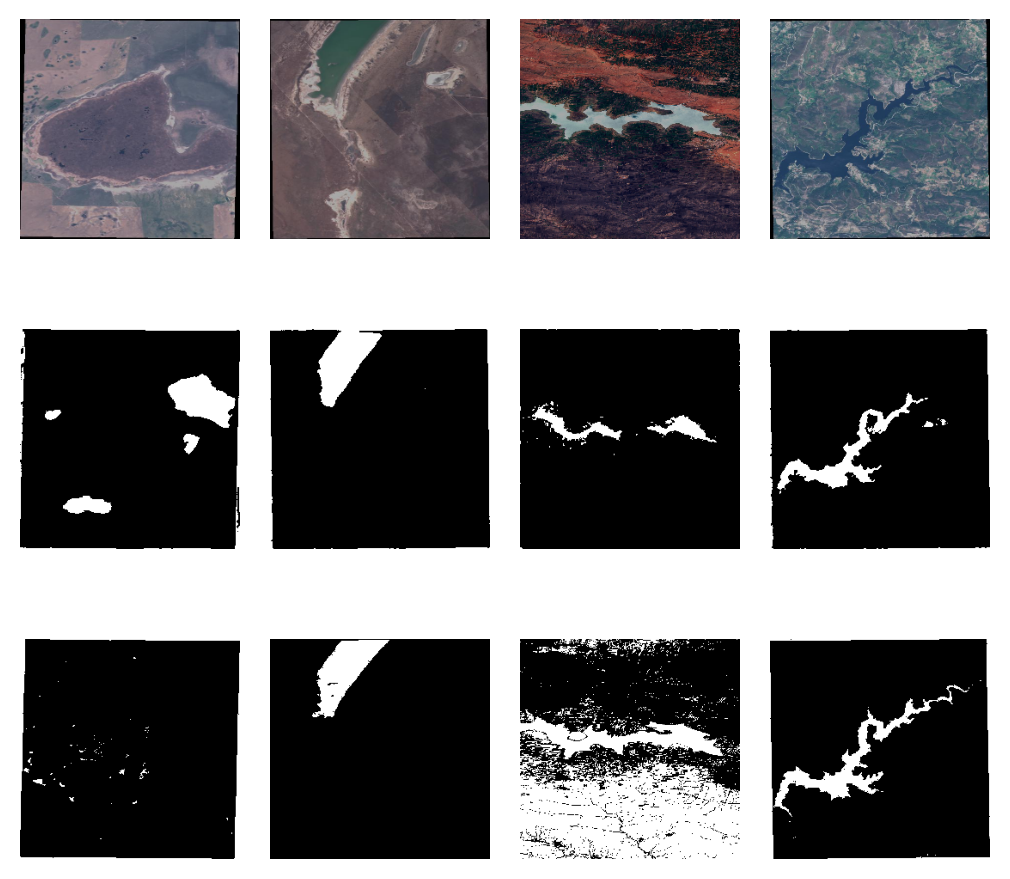

In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Define colors for background (black) and foreground (white) in BGR format
label_colours = np.array([[0, 0, 0],     # Black (Background)
                          [255, 255, 255]])  # White (Foreground)

def visualize(temp, plot=True, swap_colors=False):
    b = np.zeros(temp.shape)
    g = np.zeros(temp.shape)
    r = np.zeros(temp.shape)

    for l in [0, 1]:  # Indices: 0 (background), 1 (foreground)
        if swap_colors and l == 0:  # Swap black and white
            g[temp == l] = label_colours[1, 1]  # Use white for green
            b[temp == l] = label_colours[1, 0]  # Use white for blue
            r[temp == l] = label_colours[1, 2]  # Use white for red
        else:
            b[temp == l] = label_colours[l, 0]
            g[temp == l] = label_colours[l, 1]
            r[temp == l] = label_colours[l, 2]

    # Create the RGB output
    rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
    rgb[:, :, 0] = r / 255.0  # Red channel
    rgb[:, :, 1] = g / 255.0  # Green channel
    rgb[:, :, 2] = b / 255.0  # Blue channel
    
    if plot:
        plt.imshow(rgb)
        plt.axis('off')  # Hide axes
        plt.show()
    else:
        return rgb

# Example plotting code (assuming y_pred and y_test are available and contain the correct data)
randsample = random.sample(range(0, len(y_pred)), 4)
gs = GridSpec(3, 5)
plt.figure(dpi=200)

for i in range(4):
    output = visualize(np.argmax(y_pred[randsample[i]], axis=2), plot=False, swap_colors=False)  # Swap colors for predicted
    out_test = visualize(np.argmax(y_test[randsample[i]], axis=2), plot=False)
        
    plt.subplot(gs[i]), plt.imshow(X_test[randsample[i]]), plt.axis('off')
    plt.subplot(gs[5 + i]), plt.imshow(output), plt.axis('off')
    plt.subplot(gs[10 + i]), plt.imshow(out_test), plt.axis('off')

plt.tight_layout()
plt.show()


In [20]:
model.save('models/unet_500_epochs.h5')

In [21]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/working'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/working/__notebook__.ipynb
/kaggle/working/models/unet_500_epochs.h5
